In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_text_splitters import TokenTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.runnables import chain
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate ,MessagesPlaceholder
from langchain_classic.memory import ConversationBufferWindowMemory

In [3]:
#8주차 서브그래프 + 구조화된 출력과 안전한 제어
import os
import json
import asyncio
from datetime import datetime
from typing import Annotated, List, TypedDict, Optional, Dict, Any, Literal
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver

llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
search_tool = TavilySearchResults(k=3)

    
class ResearchState(TypedDict):
    topic:str
    logs:Annotated[List[BaseMessage] ,add_messages]
    raw_data:str
    quality:str
    retry_count:int

def research_execute_node(state: ResearchState):
    print("\[Research] 정보 수집 중...")
    topic = state["topic"]
    
    # 실제 검색 수행
    try:
        results = search_tool.invoke(topic)
        content = "\n".join([r["content"] for r in results])
    except:
        content = "검색 실패"
        
    return {
        "raw_data": content, 
        "logs": [AIMessage(content=f"검색 완료: {len(content)}자", name="researcher")]
    }
    
def research_reflect_node(state: ResearchState):
    print("[Research Sub] 정보 충분성 평가 중...")
    
    # LLM이 직접 평가
    chain = ChatPromptTemplate.from_template(
        """당신은 엄격한 연구 팀장입니다. 수집된 자료가 주제 '{topic}'을 설명하기에 충분한지 평가하세요.
        
        [수집된 자료]
        {data}
        
        자료가 주제를 포괄적으로 설명하면 'PASS', 부족하거나 편향되었다면 'FAIL'이라고만 답하세요.
        """
    ) | llm | StrOutputParser()
    
    evaluation = chain.invoke({"topic": state["topic"], "data": state["raw_data"]})
    quality = "PASS" if "PASS" in evaluation else "FAIL"
    
    print(f"      ㄴ 평가 결과: {quality}")
    return {"quality": quality, "logs": [AIMessage(content=f"평가 결과: {quality}", name="evaluator")]}

def research_revise_node(state: ResearchState):
    print(" [Research] 추가 검색(보완) 수행 중...")
    
    topic = state["topic"]
    current_data = state["raw_data"]
    
    # 1. LLM에게 "부족한 내용을 찾기 위한 검색어"를 생성하게 시킴
    query_chain = ChatPromptTemplate.from_template(
        """당신은 노련한 리서처입니다.
        주제 '{topic}'에 대해 현재 수집된 자료가 충분하지 않습니다.
        
        [현재 자료]
        {data}
        
        위 자료에서 빠진 내용이나 더 구체적인 정보가 필요한 부분을 파악하여,
        검색 엔진에 입력할 '구체적인 추가 검색어' 1개를 제안해주세요. (설명 없이 검색어만 출력)
        """
    ) | llm | StrOutputParser()
    
    # 데이터가 너무 길면 토큰 비용이 드니 뒤쪽 일부만 참고하거나 요약해서 넣을 수도 있습니다.
    # 여기서는 앞부분 2000자만 참고하도록 제한하겠습니다.
    new_query = query_chain.invoke({"topic": topic, "data": current_data[:2000]})
    print(f"      ㄴ생성된 추가 검색어: '{new_query}'")
    
    # 2. 생성된 검색어로 실제 검색 수행
    try:
        search_results = search_tool.invoke(new_query)
        new_content = "\n".join([f"- {r['content']}" for r in search_results])
    except Exception as e:
        new_content = f"추가 검색 실패: {str(e)}"
        
    # 3. 기존 데이터와 병합 (Merge)
    # 기존 데이터 + [추가 보완 데이터] 형식으로 합침
    combined_data = current_data + f"\n\n[추가 검색 결과 ({new_query})]:\n" + new_content
    
    return {
        "raw_data": combined_data, 
        "retry_count": state.get("retry_count", 0) + 1,
        "logs": [AIMessage(content=f"추가 검색 완료: {new_query}", name="researcher")]
    }
    
def research_submit_node(state: ResearchState):
    # 최종 결과 정리
    summary_chain = ChatPromptTemplate.from_template(
        "다음 자료를 바탕으로 '{topic}'에 대한 핵심 내용을 요약 정리해줘:\n\n{data}"
    ) | llm | StrOutputParser()
    final_summary = summary_chain.invoke({"topic": state["topic"], "data": state["raw_data"]})
    if "run_id" in state:
        save_step_to_file(state["run_id"], "Research_Done", {"summary": final_summary})
        
    return {"raw_data": final_summary}

research_workflow = StateGraph(ResearchState)
research_workflow.add_node("execute", research_execute_node)
research_workflow.add_node("reflect", research_reflect_node)
research_workflow.add_node("revise", research_revise_node)
research_workflow.add_node("submit", research_submit_node)

research_workflow.add_edge(START, "execute")
research_workflow.add_edge("execute", "reflect")

def route_research(state: ResearchState):
    # FAIL이고 재시도 1회 미만이면 보완(revise), 아니면 제출(submit)
    if state["quality"] == "FAIL" and state.get("retry_count", 0) < 1:
        return "revise"
    return "submit"

research_workflow.add_conditional_edges("reflect", route_research, {"submit": "submit", "revise": "revise"})
research_workflow.add_edge("revise", "submit")
research_workflow.add_edge("submit", END)

research_app = research_workflow.compile()

C:\Users\asguug\AppData\Local\Temp\ipykernel_127256\1427356914.py:18: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(k=3)


In [4]:
class WriterState(TypedDict):
    topic: str
    research_data: str
    draft: str
    critique: str
    score: float
    revision_count: int
    logs: Annotated[List[BaseMessage], add_messages]
    
def writer_execute_node(state: WriterState):
    count = state.get('revision_count', 0)
    print(f"[Writer Sub] 글 작성 중... (버전 {count + 1})")
    
    # 실제 글쓰기 수행
    chain = ChatPromptTemplate.from_template(
        """당신은 상황에 맞춰 최적의 글을 쓰는 '전문 수석 에디터'입니다.
        제공된 재료들을 바탕으로 주제 '{topic}'에 가장 적합한 형식의 문서를 작성하세요.
        
        [입력 자료]
        1. 연구 내용: {data}
        2. 코드 예제: {code} (없으면 '없음')
        3. 구조도(Mermaid): {design} (없으면 '없음')
        4. 이전 비평: {critique}
        
        [작성 지침]
        1. 형식 판단: 
           - 코드/구조도가 있다면 '기술 문서'나 '튜토리얼' 형식으로, 
           - 없다면 '에세이', '기획서', '보고서' 등 주제에 맞는 형식으로 작성하세요.
           
        2. 자료 통합 (조건부 삽입):
           - 연구 내용: 글의 논리적 근거로 활용하세요.
           - 코드 예제: 내용이 '없음'이 아니라면, 반드시 마크다운 코드 블록(```python ... ```)**으로 본문의 적절한 위치에 삽입하세요. (억지로 만들지 마세요)
           - 구조도: 내용이 '없음'이 아니라면, 반드시 Mermaid 코드 블록(```mermaid ... ```)**으로 시각화 섹션에 삽입하세요.
           
        3. 스타일:
           - 주제가 학술적이면 전문적으로, 대중적이면 읽기 쉽게 작성하세요.
           - 서론-본론-결론의 완결성 있는 구조를 갖추세요.
        """
    ) | llm | StrOutputParser()
    
    draft = chain.invoke({
        "topic": state["topic"],
        "data": state.get("research_data", "자료 없음"),
        "code": state.get("code_data", "없음"), 
        "design": state.get("design_data", "없음"), 
        "critique": state.get("critique", "없음")
    })
    if "run_id" in state:
        save_step_to_file(state["run_id"], "Write_Done", {"summary": draft})
    return {
        "draft": draft, 
        "revision_count": count + 1,
        "logs": [AIMessage(content=f"초안 v{count+1} 작성 완료", name="writer")]
    }

def writer_reflect_node(state: WriterState):
    print("[Writer Sub] 품질 평가 중...")
    
    # 실제 평가 수행
    chain = ChatPromptTemplate.from_template(
        """당신은 세계적인 저널의 '엄격한 수석 편집자'입니다. 
        아래 글이 사용자 요청 주제인 '{topic}'에 완벽하게 부합하는지 비판적으로 평가하세요.
        
        [평가 기준]
        1. 주제 적합성: 요청한 주제를 정확히 다루고 있는가?
        2. 구체성: 막연한 내용이 아니라 구체적인 사실/예시가 있는가?
        3. 논리적 흐름: 서론-본론-결론의 구조가 탄탄한가?
        
        주의: 조금이라도 모호하거나, 평범한 내용이라면 7점 미만으로 점수를 주세요. 
        완벽하지 않으면 9점 이상을 주지 마세요.
        
        형식: 점수/구체적인_피드백 (예: 6.5/주제와 관련 없는 내용이 포함되어 있고 예시가 부족합니다)
        
        [글]: {draft}
        """
    ) | llm | StrOutputParser()
    
    response = chain.invoke({
        "draft": state["draft"],
        "topic": state["topic"] 
    })
    
    try:
        score_str, fb = response.split("/", 1)
        score = float(score_str.strip().replace("점", ""))
    except:
        score, fb = 5.0, "형식 오류"
        
    print(f"      ㄴ 점수: {score}점")
    print(f"      ㄴ  피드백: {fb[:100]}...")
    
    return {
        "score": score, 
        "critique": fb,
        "logs": [AIMessage(content=f"평가: {score}점 / {fb}", name="critic")]
    }
    
writer_workflow = StateGraph(WriterState)
writer_workflow.add_node("execute", writer_execute_node)
writer_workflow.add_node("reflect", writer_reflect_node)

writer_workflow.add_edge(START, "execute")
writer_workflow.add_edge("execute", "reflect")

def route_writer(state: WriterState):
    # 8.5점 이상이거나 3번 수정했으면 종료
    if state["score"] >= 8.5 or state["revision_count"] >= 3:
        return "end"
    return "execute" # 다시 작성

writer_workflow.add_conditional_edges("reflect", route_writer, {"execute": "execute", "end": END})
writer_app = writer_workflow.compile()

In [5]:
class CodeState(TypedDict):
    topic: str
    logs: Annotated[List[BaseMessage], add_messages]
    code_result: str
    critique: str   # 리뷰 피드백 저장
    quality: str    # PASS / FAIL
    retry_count: int

def code_execute_node(state: CodeState):
    print(f"[Code Agent] '{state['topic']}' 코드 초안 작성 중...")
    
    # 초안 작성 프롬프트
    chain = ChatPromptTemplate.from_template(
        """당신은 Senior Python 개발자입니다. 
        주제 '{topic}'에 대한 Python 예제 코드를 작성하세요.
        
        [요구사항]
        1. 실행 가능한 Python 코드여야 합니다.
        2. 코드 내에 상세한 주석(Comments)을 포함하세요.
        3. 마크다운 코드 블록(```python ... ```)으로 감싸지 말고 순수 코드만 출력하거나, 
           코드 블록을 쓴다면 파싱 가능한 형태로 주세요.
        """
    ) | llm | StrOutputParser()
    
    code = chain.invoke({"topic": state["topic"]})
    
    if "run_id" in state:
        save_step_to_file(state["run_id"], "Code_Done", {"summary": code})
        
    return {
        "code_result": code, 
        "retry_count": 0,
        "logs": [AIMessage(content="코드 초안 생성 완료", name="coder")]
    }
    
def code_reflect_node(state: CodeState):
    print("[Code Agent] 코드 품질 리뷰 중...")
    
    # 리뷰 프롬프트: 엄격하게 평가
    chain = ChatPromptTemplate.from_template(
        """당신은 까다로운 코드 리뷰어(Code Reviewer)입니다.
        아래 코드를 검토하고 점수와 피드백을 제공하세요.
        
        [검토할 코드]
        {code}
        
        [평가 기준]
        1. 문법 오류(Syntax Error)가 없는가?
        2. 주석(Comments)이 충분히 작성되었는가?
        3. 실행 가능한 구조인가?
        
        [출력 형식]
        반드시 아래 형식으로만 답변하세요:
        상태: [PASS 또는 FAIL]
        피드백: [구체적인 개선점 또는 오류 내용]
        """
    ) | llm | StrOutputParser()
    
    review_result = chain.invoke({"code": state["code_result"]})
    
    # 결과 파싱 (PASS/FAIL 분리)
    try:
        status_line = review_result.split("\n")[0] # 첫 줄 "상태: PASS" 등
        quality = "PASS" if "PASS" in status_line else "FAIL"
        critique = review_result
    except:
        quality = "FAIL"
        critique = "리뷰 형식 오류 발생"

    print(f"      ㄴ 리뷰 결과: {quality}")
    if quality == "FAIL":
         print(f"      ㄴ피드백: {critique.split('피드백:')[1][:50]}...") # 로그 간소화
         
    return {
        "quality": quality, 
        "critique": critique,
        "logs": [AIMessage(content=f"리뷰 완료: {quality}", name="reviewer")]
    }
    
def code_revise_node(state: CodeState):
    print(" [Code Agent] 피드백 반영하여 코드 수정 중...")
    
    # 수정 프롬프트
    chain = ChatPromptTemplate.from_template(
        """당신은 개발자입니다. 리뷰어의 피드백을 반영하여 코드를 수정하세요.
        
        [기존 코드]
        {code}
        
        [리뷰어 피드백]
        {critique}
        
        피드백을 반영하여 개선된 '전체 코드'만 다시 출력하세요. (설명 제외)
        """
    ) | llm | StrOutputParser()
    
    new_code = chain.invoke({
        "code": state["code_result"],
        "critique": state["critique"]
    })
    if "run_id" in state:
        save_step_to_file(state["run_id"], "Code_Done", {"summary": new_code})
    
    return {
        "code_result": new_code,
        "retry_count": state["retry_count"] + 1,
        "logs": [AIMessage(content=f"코드 수정 완료 (시도 {state['retry_count']+1}회)", name="coder")]
    }
    
code_workflow = StateGraph(CodeState)

code_workflow.add_node("execute", code_execute_node)
code_workflow.add_node("reflect", code_reflect_node)
code_workflow.add_node("revise", code_revise_node)

# 흐름 정의
code_workflow.add_edge(START, "execute")
code_workflow.add_edge("execute", "reflect")

# 분기 로직 (Conditional Edge)
def route_code(state: CodeState):
    # 통과했거나, 재시도 횟수가 3회를 넘으면 종료
    if state["quality"] == "PASS" or state["retry_count"] >= 3:
        return END
    return "revise" # 실패하면 수정하러 이동

code_workflow.add_conditional_edges(
    "reflect", 
    route_code, 
    {"revise": "revise", END: END}
)

code_workflow.add_edge("revise", "reflect")

code_app = code_workflow.compile()

In [6]:
class DesignerState(TypedDict):
    topic: str
    logs: Annotated[List[BaseMessage], add_messages]
    design_result: str # Mermaid 코드 저장
    critique: str      # 평가 피드백 저장
    quality: str       # PASS / FAIL
    retry_count: int
    
def designer_execute_node(state: DesignerState):
    print(f"[Designer Agent] '{state['topic']}' 시각화 구조 설계 중...")
    
    # Mermaid 코드 생성 프롬프트
    chain = ChatPromptTemplate.from_template(
        """당신은 시스템 아키텍트입니다. 
        주제 '{topic}'의 구조나 흐름을 가장 잘 설명할 수 있는 'Mermaid 다이어그램' 코드를 작성하세요.
        
        [요구사항]
        1. 흐름도(graph TD) 또는 시퀀스 다이어그램(sequenceDiagram) 중 적절한 것을 선택하세요.
        2. 설명 텍스트 없이 오직 Mermaid 코드만 출력하세요.
        3. 마크다운 태그(```mermaid)는 제외하고 순수 코드만 주세요.
        """
    ) | llm | StrOutputParser()
    
    design = chain.invoke({"topic": state["topic"]})
    
    if "run_id" in state:
        save_step_to_file(state["run_id"], "Design_Done", {"summary": final_summary})
        
    return {
        "design_result": design,
        "retry_count": 0,
        "logs": [AIMessage(content="다이어그램 초안 생성 완료", name="designer")]
    }
    
def designer_reflect_node(state: DesignerState):
    print("[Designer Agent] 다이어그램 문법 및 적절성 검사 중...")
    
    # 평가 프롬프트
    chain = ChatPromptTemplate.from_template(
        """당신은 Mermaid 문법 전문가입니다. 
        아래 코드가 문법적으로 올바르고 주제를 잘 표현하는지 검사하세요.
        
        [검토할 코드]
        {code}
        
        [출력 형식]
        반드시 아래 형식으로만 답변하세요:
        상태: [PASS 또는 FAIL]
        피드백: [오류 내용 또는 개선점]
        """
    ) | llm | StrOutputParser()
    
    review_result = chain.invoke({"code": state["design_result"]})
    
    # 결과 파싱
    try:
        status_line = review_result.split("\n")[0]
        quality = "PASS" if "PASS" in status_line else "FAIL"
        critique = review_result
    except:
        quality = "FAIL"
        critique = "형식 오류 발생"
        
    print(f"      ㄴ 검사 결과: {quality}")
    if quality == "FAIL":
        print(f"      ㄴ피드백: {critique.split('피드백:')[1][:50]}...")

    return {
        "quality": quality,
        "critique": critique,
        "logs": [AIMessage(content=f"검사 완료: {quality}", name="reviewer")]
    }
    
def designer_revise_node(state: DesignerState):
    print("[Designer Agent] 피드백 반영하여 수정 중...")
    
    chain = ChatPromptTemplate.from_template(
        """당신은 디자이너입니다. 피드백을 반영하여 Mermaid 코드를 수정하세요.
        
        [기존 코드]
        {code}
        
        [피드백]
        {critique}
        
        수정된 전체 Mermaid 코드만 출력하세요. (설명 제외)
        """
    ) | llm | StrOutputParser()
    
    new_design = chain.invoke({
        "code": state["design_result"],
        "critique": state["critique"]
    })
    
    return {
        "design_result": new_design,
        "retry_count": state["retry_count"] + 1,
        "logs": [AIMessage(content=f"수정 완료 (시도 {state['retry_count']+1}회)", name="designer")]
    }
    
designer_workflow = StateGraph(DesignerState)

designer_workflow.add_node("execute", designer_execute_node)
designer_workflow.add_node("reflect", designer_reflect_node)
designer_workflow.add_node("revise", designer_revise_node)

# 흐름 연결
designer_workflow.add_edge(START, "execute")
designer_workflow.add_edge("execute", "reflect")

# 분기 로직
def route_design(state: DesignerState):
    if state["quality"] == "PASS" or state["retry_count"] >= 3:
        return END
    return "revise"

designer_workflow.add_conditional_edges(
    "reflect", 
    route_design, 
    {"revise": "revise", END: END}
)

# 루프 연결
designer_workflow.add_edge("revise", "reflect")

designer_app = designer_workflow.compile()

In [7]:
def update_agent_results(existing: Dict[str, Any], new_data: Dict[str, Any]) -> Dict[str, Any]:
    # 기존 딕셔너리에 새로운 데이터를 업데이트(병합)
    if existing is None:
        return new_data
    # 얕은 복사 후 업데이트하여 기존 데이터 보존
    merged = existing.copy()
    merged.update(new_data)
    return merged


class MainState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    agent_results: Annotated[Dict[str, Any], update_agent_results]
    next: List[str]

# 2-1. Supervisor (LLM 결정)
class SupervisorDecision(BaseModel):
    next: List[Literal['research_subgraph', 'code_subgraph', 'designer_subgraph', 'writer_subgraph', 'FINISH']] = Field(
        description="다음에 실행할 에이전트 목록. 병렬 실행이 필요하면 여러 개를 선택하세요."
    )
    reasoning: str = Field(description="이 결정을 내린 이유 (성찰)")


def supervisor_node(state: MainState):
    results = state.get("agent_results", {})
    messages = state.get("messages", [])
    last_user_msg = messages[-1].content if messages else ""
    
    status = {
        "research": "있음" if "research" in results else "없음",
        "code": "있음" if "code" in results else "없음",
        "design": "있음" if "design" in results else "없음",
        "final_doc": "있음" if "final_doc" in results else "없음"
    }
    
    # 규칙: 연구자료 없으면 research -> 있으면 writer_team -> 끝나면 FINISH
    system_prompt = f"""당신은 유능한 AI 프로젝트 매니저입니다. 
    사용자의 요청과 현재 작업 상태를 분석하여 최적의 작업자(들)을 지정하세요.
    
    [사용자 요청]: "{last_user_msg}"
    
    [현재 데이터 상태]
    {status}
    
    [판단 가이드]
    1. 코드/디자인 필요성 판단:
       - 요청이 '구현', '개발', '설계', '알고리즘', '구조도' 등을 포함하나요? -> Code/Designer 호출
       - 단순 '동향 파악', '분석 보고서', '에세이'인가요? -> Research만 호출 (Code/Design 생략)
    
    2. 작업 순서:
       1. **0순위: 무조건 종료**:
       - 'Final Document' 상태가 '있음'이라면, 다른 조건 볼 것 없이 무조건 'FINISH'를 선택하세요. (절대 Writer를 다시 부르지 마세요)
    
    2. **중복 실행 금지**: 
       - 이미 'Code 결과'가 '있음'이라면, 절대로 'code_subgraph'를 다시 호출하지 마세요.
       - 이미 'Research 결과'가 '있음'이라면, 절대로 'research_subgraph'를 다시 호출하지 마세요.
    
    3. **작업 흐름**:
       - (1단계) 자료 생성: 요청에 따라 Research, Code, Design 팀을 호출합니다.
       - (2단계) 문서 작성: 위 자료들이 준비되었고, 아직 'final_doc'가 '없음'이라면 -> 'writer_subgraph'를 호출하세요.
       
    4. **특수 상황**:
       - 만약 사용자가 코드만 요청했고 'Code 결과'는 있는데 'Final Document'가 없다면 -> 'writer_subgraph'를 호출하세요.
    3. 병렬 실행:
       - 연구, 코드, 디자인이 모두 필요하다고 판단되면 동시에 호출하세요.
       
    """
    
    model = llm.with_structured_output(SupervisorDecision)
    decision = model.invoke([SystemMessage(content=system_prompt)])
    
    print(f"\n[Main Supervisor] 지시: {decision.next}")
    return {"next": decision.next}

def call_research_subgraph(state: MainState):
    print("[Main] 'Research 서브그래프' 호출")
    topic = state["messages"][0].content # 사용자 질문
    
    # 서브그래프 실행
    output = research_app.invoke({"topic": topic})
    
    return {"agent_results": {"research": output["raw_data"]}}

def call_writer_subgraph(state: MainState):
    print("\n[Main] 'Writer 서브그래프' 호출")
    
    topic = state["messages"][0].content
    results = state["agent_results"]
    
    output = writer_app.invoke({
        "topic": topic, 
        "research_data": results.get("research", ""),
        "code_data": results.get("code", ""),
        "design_data": results.get("design", ""),
        "revision_count": 0
    })
    
    # 최종 문서만 리턴
    return {"agent_results": {"final_doc": output["draft"]}}

def call_code_subgraph(state: MainState):
    print("[Main] 'Code 팀' (서브그래프) 호출")
    
    topic = state["messages"][0].content
    
    output = code_app.invoke({
        "topic": topic,
        "retry_count": 0 
    })
    
    return {"agent_results": {"code": output["code_result"]}}

def call_designer_subgraph(state: MainState):
    print("[Main] 'Designer 팀' (서브그래프) 호출")
    
    topic = state["messages"][0].content
    
    # Designer Subgraph 실행
    output = designer_app.invoke({
        "topic": topic,
        "retry_count": 0
    })
    print(f"[Main] Designer 팀 작업 완료")
    
    return {"agent_results": {"design": output["design_result"]}}

main_workflow = StateGraph(MainState)
main_workflow.add_node("supervisor", supervisor_node)
main_workflow.add_node("research_subgraph", call_research_subgraph)
main_workflow.add_node("writer_subgraph", call_writer_subgraph)
main_workflow.add_node("code_subgraph", call_code_subgraph)
main_workflow.add_node("designer_subgraph", call_designer_subgraph)

main_workflow.add_edge(START, "supervisor")
main_workflow.add_edge("research_subgraph", "supervisor")
main_workflow.add_edge("writer_subgraph", "supervisor")
main_workflow.add_edge("code_subgraph", "supervisor")
main_workflow.add_edge("designer_subgraph", "supervisor")

def route_supervisor(state: MainState):
    next_agents = state["next"]
    
    # 종료 조건
    if "FINISH" in next_agents:
        return END
    
    # 리스트 반환 -> LangGraph가 자동으로 병렬 실행함
    return next_agents

# Supervisor의 'next' 값에 따라 분기
main_workflow.add_conditional_edges(
    "supervisor",
    route_supervisor,
    # 매핑은 명시적으로 모든 가능성을 열어둡니다
    {
        "research_subgraph": "research_subgraph",
        "code_subgraph": "code_subgraph",
        "designer_subgraph": "designer_subgraph",
        "writer_subgraph": "writer_subgraph",
        END: END
    }
)

memory = MemorySaver()
app = main_workflow.compile(checkpointer=memory)


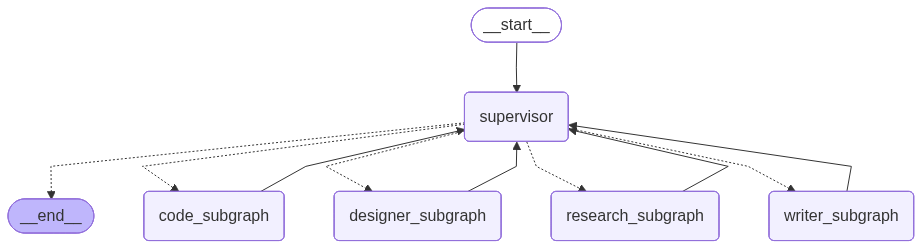

In [8]:
from IPython.display import Image, display

try:
    # 그래프를 Mermaid PNG로 변환하여 표시
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    # 라이브러리 버전이나 환경 문제로 이미지 생성이 안 될 경우 텍스트로 출력
    print("이미지 렌더링 실패. Mermaid 코드로 대체합니다:")
    print(app.get_graph().draw_mermaid())

=== Research Subgraph 구조 ===


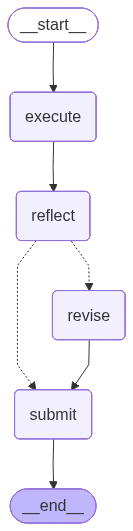


=== Writer Subgraph 구조 ===


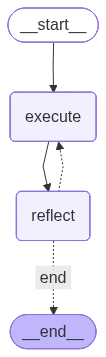


=== Code Subgraph 구조 ===


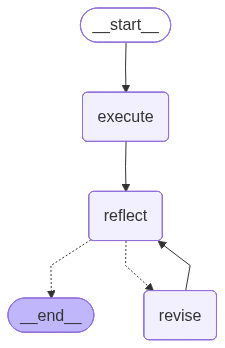

In [9]:
print("=== Research Subgraph 구조 ===")
try:
    display(Image(research_app.get_graph().draw_mermaid_png()))
except:
    print(research_app.get_graph().draw_mermaid())

print("\n=== Writer Subgraph 구조 ===")
try:
    display(Image(writer_app.get_graph().draw_mermaid_png()))
except:
    print(writer_app.get_graph().draw_mermaid())

print("\n=== Code Subgraph 구조 ===")
try:
    display(Image(code_app.get_graph().draw_mermaid_png()))
except:
    print(code_app.get_graph().draw_mermaid())

In [ ]:
import asyncio
import json
import os
import sys
import builtins
from functools import partial
from datetime import datetime
from enum import Enum

# --- LangChain & RAG 관련 임포트 ---
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.documents import Document

# 🚨 출력 버퍼링 해제 (실시간 로그용)
builtins.print = partial(builtins.print, flush=True)

# ==========================================
# 1. RAG 엔진 (기존 DB 연동)
# ==========================================
class RAGEngine:
    def __init__(self, pdf_dir="./data", persist_dir="./chroma_recur_db"): # 사용자 폴더명 반영
        self.pdf_dir = pdf_dir
        self.persist_dir = persist_dir
        self.collection_name = 'recur_chunks_collection' # 사용자 컬렉션명 반영
        
        # 3주차 코드와 동일한 모델 설정
        self.llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
        self.embeddings = OpenAIEmbeddings(model='text-embedding-3-small')
        
        self.vectorstore = None
        self.retriever = None
        
        # 초기화 실행
        self._initialize_db()

    def _initialize_db(self):
        """기존 DB가 있으면 로드하고, 없으면 새로 만듭니다."""
        print(f"📚 [RAG 엔진] DB 경로 확인: {self.persist_dir}")
        
        # 1. 기존 DB 폴더가 있는지 확인
        if os.path.exists(self.persist_dir) and os.listdir(self.persist_dir):
            print("   ✅ 기존 'chroma_recur_db'를 발견했습니다. 로드 중...")
            self.vectorstore = Chroma(
                persist_directory=self.persist_dir,
                embedding_function=self.embeddings,
                collection_name=self.collection_name
            )
        else:
            # 2. 없으면 새로 구축 (예외 처리)
            print("   ⚠️ 기존 DB가 없습니다. 문서를 새로 로드합니다...")
            docs = []
            if os.path.exists(self.pdf_dir):
                for f in os.listdir(self.pdf_dir):
                    if f.endswith('.pdf'):
                        print(f"      - 로드 중: {f}")
                        loader = PyPDFLoader(os.path.join(self.pdf_dir, f))
                        docs.extend(loader.load())
            
            if not docs:
                print("      (PDF 파일이 없어 테스트용 더미 데이터를 생성합니다)")
                from langchain_core.documents import Document
                docs = [Document(page_content="RAG는 검색 증강 생성 기술입니다.", metadata={"source": "dummy"})]

            # 3주차 코드의 Splitter 설정 반영
            text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
            splits = text_splitter.split_documents(docs)
            
            self.vectorstore = Chroma.from_documents(
                documents=splits,
                embedding=self.embeddings,
                collection_name=self.collection_name,
                persist_directory=self.persist_dir
            )
            
        # Retriever 설정
        self.retriever = self.vectorstore.as_retriever(search_kwargs={'k': 3})
        print("✅ [RAG 엔진] 준비 완료!")

    async def retrieve(self, query):
        """비동기 문서 검색"""
        # invoke 대신 ainvoke 사용 (비동기)
        docs = await self.retriever.ainvoke(query)
        return docs

    async def generate_answer(self, query, context_docs):
        """검색된 문서를 바탕으로 답변 생성"""
        context_text = "\n\n".join([doc.page_content for doc in context_docs])
        
        prompt = ChatPromptTemplate.from_template(
            """당신은 AI 어시스턴트입니다. 아래 컨텍스트를 기반으로 질문에 답하세요.
            문서에 없는 내용은 '정보가 없습니다'라고 답하세요.
            
            컨텍스트:
            {context}
            
            질문: {question}
            """
        )
        chain = prompt | self.llm | StrOutputParser()
        return await chain.ainvoke({"context": context_text, "question": query})

# ==========================================
# 2. 파이프라인 프로세서 (나머지는 동일)
# ==========================================

class Step(Enum):
    PLAN = 1      # 계획
    READ = 2      # 검색 (Retrieval)
    DRAFT = 3     # 생성 (Generation)
    FINALIZE = 4  # 정리

STEP_INFO = {
    Step.PLAN: "질문 분석 및 계획",
    Step.READ: "문서 검색 (Retrieval)",
    Step.DRAFT: "답변 생성 (Generation)",
    Step.FINALIZE: "최종 결과 포맷팅"
}

def save_step_to_file(run_id, step_num, step_name, result):
    directory = f"runs/{run_id}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    filename = f"{directory}/step_{step_num:02d}.json"
    
    # 직렬화 처리
    serializable_result = result
    if hasattr(result, 'page_content'): 
        serializable_result = result.page_content
    elif isinstance(result, list): 
        serializable_result = [d.page_content if hasattr(d, 'page_content') else str(d) for d in result]

    data = {
        "step": step_num,
        "step_name": step_name,
        "result": serializable_result,
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    print(f"   💾 [파일 저장] {filename}")

def load_checkpoint(run_id):
    path = f"runs/{run_id}/checkpoint.json"
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    return None

def save_checkpoint(run_id, step_num, user_goal, context_data):
    directory = f"runs/{run_id}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # 🌟 [핵심] Document 객체 리스트를 딕셔너리 리스트로 변환 (JSON 저장용)
    serializable_context = context_data
    if isinstance(context_data, list) and context_data:
        # 내용물이 Document 객체인지 확인
        if hasattr(context_data[0], 'page_content'):
            serializable_context = [
                {"page_content": doc.page_content, "metadata": doc.metadata} 
                for doc in context_data
            ]

    data = {
        "run_id": run_id,
        "completed_step": step_num,
        "user_goal": user_goal,
        "context_data": serializable_context # 변환된 데이터 저장
    }
    
    with open(f"{directory}/checkpoint.json", "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

class PipelineProcessor:
    def __init__(self):
        self.rag_engine = RAGEngine()
        self.stop_flag = False

    def stop(self):
        self.stop_flag = True
        print("\n🛑 [시스템] STOP 명령 수신! (단계 완료 후 멈춤)")

    async def run_pipeline(self, run_id, user_goal, resume=False):
        self.stop_flag = False
        start_step = 1
        current_data = None 

        # --- Resume 로직 (데이터 복원) ---
        if resume:
            ckpt = load_checkpoint(run_id)
            if ckpt:
                start_step = ckpt['completed_step'] + 1
                loaded_data = ckpt.get('context_data')
                
                # 🌟 [핵심] 딕셔너리를 다시 Document 객체로 복원
                if isinstance(loaded_data, list) and loaded_data:
                    # 딕셔너리 형태라면 Document 객체로 변환
                    if isinstance(loaded_data[0], dict) and 'page_content' in loaded_data[0]:
                        current_data = [
                            Document(page_content=d['page_content'], metadata=d.get('metadata', {})) 
                            for d in loaded_data
                        ]
                        print(f"   🔄 [시스템] 저장된 문서 {len(current_data)}개를 메모리로 복원했습니다.")
                    else:
                        current_data = loaded_data
                else:
                    current_data = loaded_data

                print(f"🔄 [Resume] Step {start_step}부터 작업을 이어갑니다.")
            else:
                print("⚠️ 체크포인트 없음. 처음부터 시작합니다.")

        # --- 메인 루프 (Step 1~4) ---
        for step_num in range(start_step, 5):
            if self.stop_flag:
                print(f"🛑 Step {step_num} 진입 전 중단되었습니다.")
                return 

            step_enum = Step(step_num)
            step_name = STEP_INFO[step_enum]
            
            print(f"   ▶ [실행] Step {step_num}: {step_name}")
            
            output_data = None
            
            if step_enum == Step.PLAN:
                output_data = f"질문 '{user_goal}'에 대해 기존 DB를 검색합니다."
                await asyncio.sleep(0.5)
                
            elif step_enum == Step.READ:
                print(f"      🔎 '{user_goal}' 관련 문서 검색 중...")
                docs = await self.rag_engine.retrieve(user_goal)
                output_data = docs
                print(f"      📄 관련 문서 {len(docs)}개 발견")
                
            elif step_enum == Step.DRAFT:
                # 데이터가 있으면(Resume 등) 사용, 없으면 검색
                if current_data: 
                    context_docs = current_data 
                    print(f"      📚 [기억 활용] 저장된 문서 {len(context_docs)}개를 사용합니다.")
                else:
                    context_docs = await self.rag_engine.retrieve(user_goal)
                    
                print(f"      ✍️ LLM이 답변 작성 중...")
                answer = await self.rag_engine.generate_answer(user_goal, context_docs)
                output_data = answer
                
            elif step_enum == Step.FINALIZE:
                final_text = f"=== 최종 답변 ===\n\n[질문]: {user_goal}\n\n[내용]:\n{current_data}\n\n[Generated by RAG Agent]"
                output_data = final_text

            # 결과 저장
            save_step_to_file(run_id, step_num, step_name, output_data)
            
            # 체크포인트 저장 (검색된 문서 등 중요한 데이터를 저장)
            save_data_for_next = output_data
            save_checkpoint(run_id, step_num, user_goal, save_data_for_next)
            
            current_data = output_data

        if not self.stop_flag:
            print(f"✅ [완료] Run ID: {run_id}")

class AgentQueueSystem:
    def __init__(self):
        self.queue = asyncio.Queue()
        self.processor = PipelineProcessor() 

    async def add_job(self, run_id, user_message, thread_id="1"):
        await self.queue.put({
            "run_id": run_id, 
            "message": user_message, 
            "resume": False
        })
        print(f"📥 [시스템] 요청 접수: {run_id}")

    async def add_resume_job(self, run_id, user_message):
        await self.queue.put({
            "run_id": run_id, 
            "message": user_message, 
            "resume": True
        })
        print(f"📥 [시스템] 재개 요청 접수: {run_id}")

    async def worker(self):
        print("👷 [워커] 가동 중... (RAG 엔진 준비됨)")
        while True:
            job = await self.queue.get()
            try:
                run_id = job["run_id"]
                msg = job["message"]
                is_resume = job["resume"]
                
                print(f"\n🚀 [시작] {run_id}: {msg}")
                await self.processor.run_pipeline(run_id, msg, resume=is_resume)
                
            except Exception as e:
                print(f"❌ [에러] {e}")
            finally:
                self.queue.task_done()
                print("\n>>> 명령 입력: ", end="") 

    def trigger_stop(self):
        self.processor.stop()

# ==========================================
# 3. 인터랙티브 실행
# ==========================================
async def interactive_mode():
    # 여기서 RAG 엔진이 초기화되며 'chroma_recur_db'를 로드합니다.
    system = AgentQueueSystem()
    worker_task = asyncio.create_task(system.worker())
    
    print("\n" + "="*50)
    print("🎮 [RAG 파이프라인] 명령어를 입력하세요.")
    print("1. 요청: req <run_id> <질문>  (예: req run_1 RAG의 장점은?)")
    print("2. 중단: stop")
    print("3. 재개: resume <run_id> <질문>")
    print("4. 종료: exit")
    print("="*50 + "\n")

    while True:
        command = await asyncio.get_event_loop().run_in_executor(None, input, ">>> 명령 입력: ")
        parts = command.split()
        if not parts: continue
        cmd = parts[0].lower()
        
        if cmd in ["exit", "종료"]:
            if not worker_task.done(): worker_task.cancel()
            break
        elif cmd == "stop":
            system.trigger_stop()
        elif cmd == "req":
            if len(parts) < 3:
                print("⚠️ 형식 오류! 예: req run_1 RAG란?")
                continue
            await system.add_job(parts[1], " ".join(parts[2:]))
        elif cmd == "resume":
            if len(parts) < 3:
                print("⚠️ 형식 오류! 예: resume run_1 RAG란?")
                continue
            await system.add_resume_job(parts[1], " ".join(parts[2:]))
        else:
            print("❓ 알 수 없는 명령어")

if __name__ == "__main__":
    await interactive_mode()

📚 [RAG 엔진] DB 경로 확인: ./chroma_recur_db
   ✅ 기존 'chroma_recur_db'를 발견했습니다. 로드 중...
✅ [RAG 엔진] 준비 완료!

🎮 [RAG 파이프라인] 명령어를 입력하세요.
1. 요청: req <run_id> <질문>  (예: req run_1 RAG의 장점은?)
2. 중단: stop
3. 재개: resume <run_id> <질문>
4. 종료: exit

👷 [워커] 가동 중... (RAG 엔진 준비됨)
📥 [시스템] 요청 접수: test_01

🚀 [시작] test_01: RAG의 장점이 뭐야?
   ▶ [실행] Step 1: 질문 분석 및 계획
